In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
import joblib
import os
import matplotlib.pyplot as plt

# ======================
# 1. Load and Preprocess Data
# ======================
def load_and_preprocess():
    # Load data
    train = pd.read_parquet("/kaggle/input/unsw-nb15/UNSW_NB15_training-set.parquet")
    test = pd.read_parquet("/kaggle/input/unsw-nb15/UNSW_NB15_testing-set.parquet")
    df = pd.concat([train, test])
    
    # Preprocessing
    df = df.drop(columns=['id', 'attack_cat'], errors='ignore')
    cat_cols = ['proto', 'service', 'state']
    for col in cat_cols:
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col].astype(str))
    
    X = df.drop('label', axis=1)
    y = df['label']
    
    # Scale numerical features
    num_cols = X.select_dtypes(include=[np.number]).columns
    scaler = StandardScaler()
    X[num_cols] = scaler.fit_transform(X[num_cols])
    
    return X, y

X, y = load_and_preprocess()


In [2]:
# ======================
# 2. Experiment Setup
# ======================
ratios = [
    (10, 90), (20, 80), (30, 70), 
    (40, 60), (50, 50), (60, 40),
    (70, 30), (80, 20), (90, 10)
]

results = {}
os.makedirs('saved_models', exist_ok=True)

Random Forest

In [3]:
# ======================
# 3. Training and Evaluation(Random Forest)
# ======================
for train_ratio, test_ratio in ratios:
    print(f"\n=== Training with {train_ratio}:{test_ratio} split ===")
    
    # Split data (stratified for labeled portion)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, 
        test_size=test_ratio/100, 
        stratify=y,
        random_state=42
    )
    
    # Train Random Forest
    rf = RandomForestClassifier(
        n_estimators=100,
        class_weight='balanced',
        random_state=42,
        n_jobs=-1
    )
    rf.fit(X_train, y_train)
    
    # Evaluate
    y_pred = rf.predict(X_test)
    report = classification_report(y_test, y_pred, output_dict=True)
    
    # Store results
    results[f"{train_ratio}:{test_ratio}"] = {
        'model': rf,
        'accuracy': report['accuracy'],
        'precision_0': report['0']['precision'],
        'recall_0': report['0']['recall'],
        'f1_0': report['0']['f1-score'],
        'precision_1': report['1']['precision'],
        'recall_1': report['1']['recall'],
        'f1_1': report['1']['f1-score']
    }
    
    # Save model
    joblib.dump(rf, f'saved_models/rf_{train_ratio}_{test_ratio}.joblib')
    print(f"Model saved for {train_ratio}:{test_ratio} split")



=== Training with 10:90 split ===
Model saved for 10:90 split

=== Training with 20:80 split ===
Model saved for 20:80 split

=== Training with 30:70 split ===
Model saved for 30:70 split

=== Training with 40:60 split ===
Model saved for 40:60 split

=== Training with 50:50 split ===
Model saved for 50:50 split

=== Training with 60:40 split ===
Model saved for 60:40 split

=== Training with 70:30 split ===
Model saved for 70:30 split

=== Training with 80:20 split ===
Model saved for 80:20 split

=== Training with 90:10 split ===
Model saved for 90:10 split


In [4]:
# ======================
# 4. Results Analysis
# ======================
# Create results dataframe
results_df = pd.DataFrame.from_dict(results, orient='index')

# Save results to CSV
results_df.to_csv('/kaggle/working/model_results.csv')
print("\nResults saved to model_results.csv")

# Save models and results in Kaggle's working directory
os.makedirs('/kaggle/working/saved_models', exist_ok=True)
for ratio, result in results.items():
    train_ratio = ratio.split(':')[0]
    joblib.dump(result['model'], f'/kaggle/working/saved_models/rf_{train_ratio}.joblib')

# Create zip archive of results
import zipfile
with zipfile.ZipFile('/kaggle/working/models_and_results.zip', 'w') as zipf:
    zipf.write('/kaggle/working/model_results.csv')
    for file in os.listdir('/kaggle/working/saved_models'):
        zipf.write(f'/kaggle/working/saved_models/{file}')


Results saved to model_results.csv


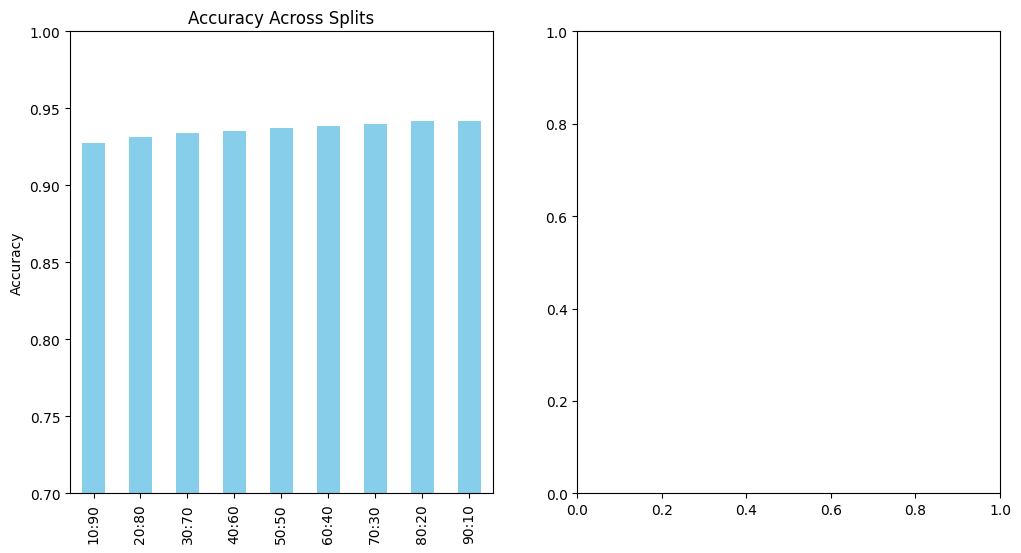

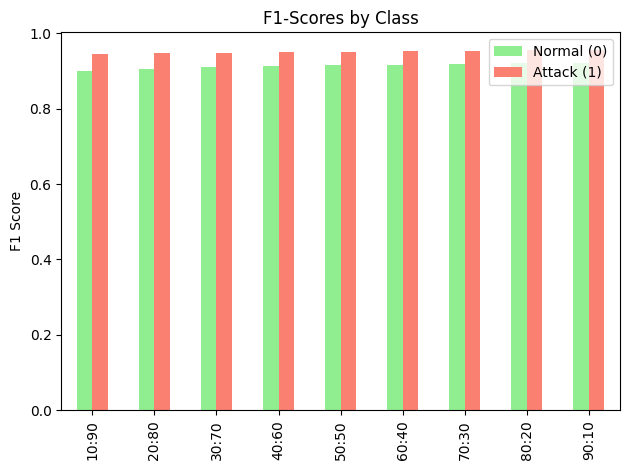


=== Performance Summary ===
       accuracy      f1_0      f1_1
10:90  0.927626  0.899521  0.943445
20:80  0.931614  0.905720  0.946349
30:70  0.933937  0.909045  0.948131
40:60  0.935636  0.911511  0.949424
50:50  0.937580  0.914279  0.950921
60:40  0.938653  0.915890  0.951720
70:30  0.939562  0.917131  0.952436
80:20  0.941535  0.919890  0.953971
90:10  0.942021  0.920625  0.954331


In [5]:
# ======================
# 5. Visualization
# ======================
plt.figure(figsize=(12, 6))

# Accuracy plot
plt.subplot(1, 2, 1)
results_df['accuracy'].plot(kind='bar', color='skyblue')
plt.title('Accuracy Across Splits')
plt.ylabel('Accuracy')
plt.ylim(0.7, 1.0)

# F1-Score comparison
plt.subplot(1, 2, 2)
results_df[['f1_0', 'f1_1']].plot(kind='bar', color=['lightgreen', 'salmon'])
plt.title('F1-Scores by Class')
plt.ylabel('F1 Score')
plt.legend(['Normal (0)', 'Attack (1)'])

plt.tight_layout()
plt.savefig('/kaggle/working/results_comparison.png')
plt.show()

# Print summary table
print("\n=== Performance Summary ===")
print(results_df[['accuracy', 'f1_0', 'f1_1']])

SSl

In [39]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

In [40]:
# Load your dataset
train = pd.read_parquet("/kaggle/input/unsw-nb15/UNSW_NB15_training-set.parquet")
test = pd.read_parquet("/kaggle/input/unsw-nb15/UNSW_NB15_testing-set.parquet")

df = pd.concat([train, test])

# Drop unnecessary columns
df = df.drop(columns=['id', 'attack_cat'], errors='ignore')

# Encode categorical columns
cat_cols = ['proto', 'service', 'state']
for col in cat_cols:
    df[col] = pd.factorize(df[col])[0]

# Separate features and labels
X = df.drop('label', axis=1)
y = df['label']

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X = pd.DataFrame(X_scaled, columns=X.columns)


In [41]:
def build_encoder(input_dim):
    inputs = layers.Input(shape=(input_dim,))
    x = layers.Dense(256, activation='swish')(inputs)
    x = layers.Dense(128, activation='swish')(x)
    projection = layers.Dense(64)(x)  # projection head output
    return models.Model(inputs, projection)

def contrastive_loss(z1, z2, temperature=0.1):
    z1 = tf.math.l2_normalize(z1, axis=1)
    z2 = tf.math.l2_normalize(z2, axis=1)
    sim = tf.matmul(z1, z2, transpose_b=True) / temperature
    return tf.reduce_mean(
        tf.nn.softmax_cross_entropy_with_logits(
            logits=sim,
            labels=tf.eye(tf.shape(z1)[0])
        )
    )


In [42]:
def augment_batch(X):
    mask = (np.random.rand(*X.shape) > 0.15).astype(np.float32)
    noise = np.random.normal(0, 0.05, size=X.shape).astype(np.float32)
    return X * mask + noise


In [43]:
# For example, use 80% train and 20% test split for now
X_train, X_test, y_train, y_test = train_test_split(
    X.values.astype(np.float32),
    y.values,
    test_size=0.2,
    stratify=y,
    random_state=42
)


In [44]:
encoder = build_encoder(X_train.shape[1])
optimizer = tf.keras.optimizers.Adam(3e-4)


In [47]:
batch_size = 512
epochs = 50
num_samples = X_train.shape[0]


In [48]:
for epoch in range(epochs):
    print(f"Epoch {epoch+1}/{epochs}")
    
    # Shuffle indices
    idx = np.random.permutation(num_samples)
    X_shuffled = X_train[idx]
    
    # Batch training
    for i in range(0, num_samples, batch_size):
        batch = X_shuffled[i:i+batch_size]
        if batch.shape[0] < 2:
            continue
        
        # Create two augmented views for contrastive learning
        x1 = augment_batch(batch)
        x2 = augment_batch(batch)
        
        with tf.GradientTape() as tape:
            z1 = encoder(x1, training=True)
            z2 = encoder(x2, training=True)
            loss = contrastive_loss(z1, z2)
        
        grads = tape.gradient(loss, encoder.trainable_weights)
        optimizer.apply_gradients(zip(grads, encoder.trainable_weights))
        
    print(f"Loss: {loss.numpy():.4f}")


Epoch 1/2
Loss: 2.0282
Epoch 2/2
Loss: 1.9350


In [ ]:
# Extract embeddings
X_train_ssl = encoder.predict(X_train)
X_test_ssl = encoder.predict(X_test)

# Train RandomForest on SSL embeddings
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_ssl, y_train)

# Evaluate
y_pred = rf.predict(X_test_ssl)
print(classification_report(y_test, y_pred))



--- Training with train:test = 10:90 ---
Epoch 1/50, Loss: 2.1718
Epoch 2/50, Loss: 2.0313
Epoch 3/50, Loss: 1.9474
Epoch 4/50, Loss: 1.8850
Epoch 5/50, Loss: 1.8506
Epoch 6/50, Loss: 1.5367
Epoch 7/50, Loss: 1.5536
Epoch 8/50, Loss: 1.7645
Epoch 9/50, Loss: 1.4893
Epoch 10/50, Loss: 1.6363
Epoch 11/50, Loss: 1.6700
Epoch 12/50, Loss: 1.5668
Epoch 13/50, Loss: 1.6861
Epoch 14/50, Loss: 1.4177
Epoch 15/50, Loss: 1.4655
Epoch 16/50, Loss: 1.5369
Epoch 17/50, Loss: 1.3138
Epoch 18/50, Loss: 1.4746
Epoch 19/50, Loss: 1.6779
Epoch 20/50, Loss: 1.5201
Epoch 21/50, Loss: 1.5187
Epoch 22/50, Loss: 1.4478
Epoch 23/50, Loss: 1.6196
Epoch 24/50, Loss: 1.3758
Epoch 25/50, Loss: 1.5946
Epoch 26/50, Loss: 1.5899
Epoch 27/50, Loss: 1.4800
Epoch 28/50, Loss: 1.2713
Epoch 29/50, Loss: 1.4082
Epoch 30/50, Loss: 1.4395
Epoch 31/50, Loss: 1.3161
Epoch 32/50, Loss: 1.5964
Epoch 33/50, Loss: 1.5079
Epoch 34/50, Loss: 1.2035
Epoch 35/50, Loss: 1.4442
Epoch 36/50, Loss: 1.4615
Epoch 37/50, Loss: 1.5062
Epoch

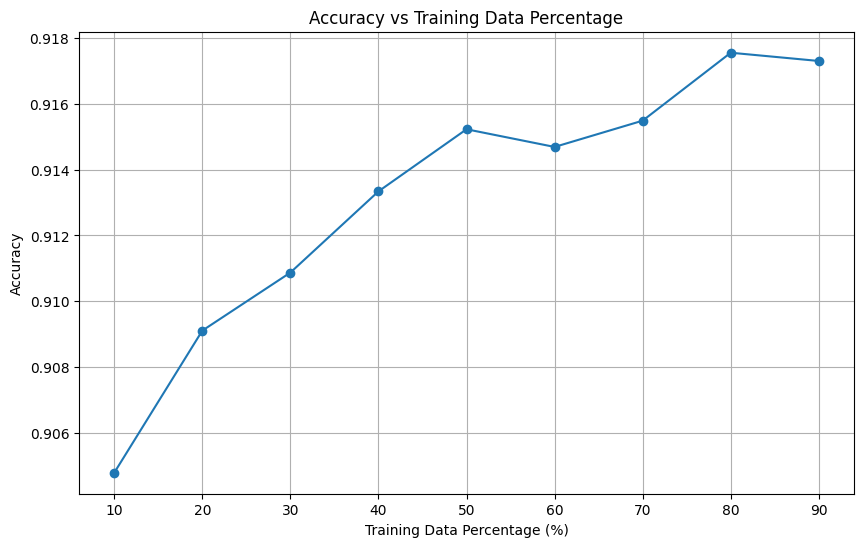

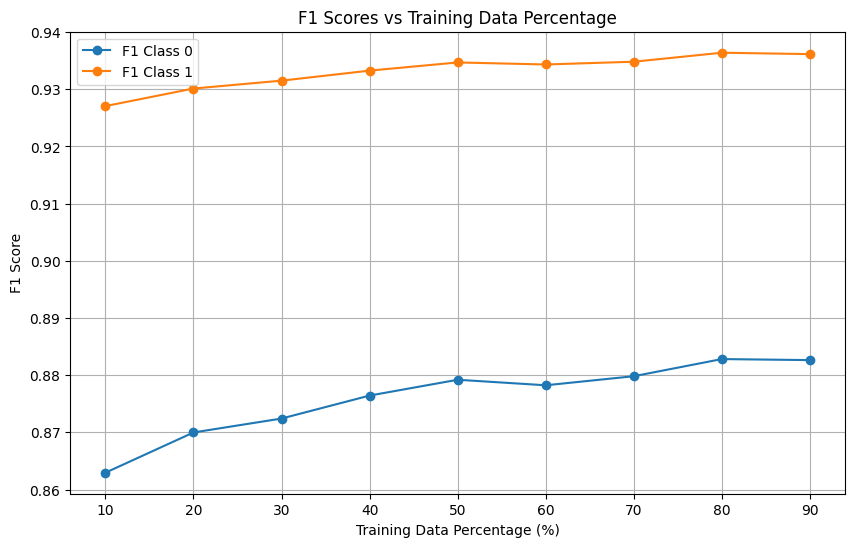

In [51]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

# Step 1: Load & preprocess data
train = pd.read_parquet("/kaggle/input/unsw-nb15/UNSW_NB15_training-set.parquet")
test = pd.read_parquet("/kaggle/input/unsw-nb15/UNSW_NB15_testing-set.parquet")
df = pd.concat([train, test])
df = df.drop(columns=['id', 'attack_cat'], errors='ignore')

cat_cols = ['proto', 'service', 'state']
for col in cat_cols:
    df[col] = pd.factorize(df[col])[0]

X = df.drop('label', axis=1)
y = df['label']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X = pd.DataFrame(X_scaled, columns=X.columns)

# Step 2: Define encoder model & loss
def build_encoder(input_dim):
    inputs = layers.Input(shape=(input_dim,))
    x = layers.Dense(256, activation='swish')(inputs)
    x = layers.Dense(128, activation='swish')(x)
    projection = layers.Dense(64)(x)
    return models.Model(inputs, projection)

def contrastive_loss(z1, z2, temperature=0.1):
    z1 = tf.math.l2_normalize(z1, axis=1)
    z2 = tf.math.l2_normalize(z2, axis=1)
    sim = tf.matmul(z1, z2, transpose_b=True) / temperature
    return tf.reduce_mean(
        tf.nn.softmax_cross_entropy_with_logits(
            logits=sim,
            labels=tf.eye(tf.shape(z1)[0])
        )
    )

def augment_batch(X):
    mask = (np.random.rand(*X.shape) > 0.15).astype(np.float32)
    noise = np.random.normal(0, 0.05, size=X.shape).astype(np.float32)
    return X * mask + noise

# Step 3: Train & evaluate for multiple ratios
ratios = [(10,90), (20,80), (30,70), (40,60), (50,50), (60,40), (70,30), (80,20), (90,10)]
results = []

for train_pct, test_pct in ratios:
    print(f"\n--- Training with train:test = {train_pct}:{test_pct} ---")
    
    X_train, X_test, y_train, y_test = train_test_split(
        X.values.astype(np.float32), y.values,
        test_size=test_pct/100,
        stratify=y,
        random_state=42
    )
    
    encoder = build_encoder(X_train.shape[1])
    optimizer = tf.keras.optimizers.Adam(3e-4)
    
    batch_size = 512
    epochs = 50
    num_samples = X_train.shape[0]
    
    # Custom training loop
    for epoch in range(epochs):
        idx = np.random.permutation(num_samples)
        X_shuffled = X_train[idx]
        for i in range(0, num_samples, batch_size):
            batch = X_shuffled[i:i+batch_size]
            if batch.shape[0] < 2:
                continue
            x1 = augment_batch(batch)
            x2 = augment_batch(batch)
            with tf.GradientTape() as tape:
                z1 = encoder(x1, training=True)
                z2 = encoder(x2, training=True)
                loss = contrastive_loss(z1, z2)
            grads = tape.gradient(loss, encoder.trainable_weights)
            optimizer.apply_gradients(zip(grads, encoder.trainable_weights))
        print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.numpy():.4f}")
    
    # Extract embeddings
    X_train_ssl = encoder.predict(X_train)
    X_test_ssl = encoder.predict(X_test)
    
    # Train RandomForest on embeddings
    rf = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
    rf.fit(X_train_ssl, y_train)
    y_pred = rf.predict(X_test_ssl)
    
    report = classification_report(y_test, y_pred, output_dict=True)
    acc = report['accuracy']
    f1_0 = report['0']['f1-score']
    f1_1 = report['1']['f1-score']
    
    results.append({
        'train_pct': train_pct,
        'test_pct': test_pct,
        'accuracy': acc,
        'f1_class_0': f1_0,
        'f1_class_1': f1_1
    })
    
    print(f"Accuracy: {acc:.4f}, F1 Class 0: {f1_0:.4f}, F1 Class 1: {f1_1:.4f}")

# Step 4: Visualize results
results_df = pd.DataFrame(results)
plt.figure(figsize=(10,6))
plt.plot(results_df['train_pct'], results_df['accuracy'], marker='o')
plt.title('Accuracy vs Training Data Percentage')
plt.xlabel('Training Data Percentage (%)')
plt.ylabel('Accuracy')
plt.grid(True)
plt.show()

plt.figure(figsize=(10,6))
plt.plot(results_df['train_pct'], results_df['f1_class_0'], marker='o', label='F1 Class 0')
plt.plot(results_df['train_pct'], results_df['f1_class_1'], marker='o', label='F1 Class 1')
plt.title('F1 Scores vs Training Data Percentage')
plt.xlabel('Training Data Percentage (%)')
plt.ylabel('F1 Score')
plt.legend()
plt.grid(True)
plt.show()


In [53]:

def save_results(output_dir, ratio, encoder, rf, X_train_ssl, X_test_ssl, y_train, y_test, report):
    """Centralized function to save all results"""
    train_pct, test_pct = ratio
    
    # Save models
    encoder.save(f"{output_dir}/models/encoder_{train_pct}_{test_pct}.h5")
    joblib.dump(rf, f"{output_dir}/models/rf_{train_pct}_{test_pct}.joblib")
    
    # Save embeddings
    np.savez(f"{output_dir}/embeddings/embeddings_{train_pct}_{test_pct}.npz",
             X_train=X_train_ssl, X_test=X_test_ssl,
             y_train=y_train, y_test=y_test)
    
    # Save metrics
    result = {
        'train_pct': train_pct,
        'test_pct': test_pct,
        'accuracy': report['accuracy'],
        'precision_0': report['0']['precision'],
        'recall_0': report['0']['recall'],
        'f1_0': report['0']['f1-score'],
        'precision_1': report['1']['precision'],
        'recall_1': report['1']['recall'],
        'f1_1': report['1']['f1-score'],
        'timestamp': timestamp
    }
    
    with open(f"{output_dir}/metrics/result_{train_pct}_{test_pct}.json", 'w') as f:
        json.dump(result, f, indent=4)
    
    return result


MoCo

In [63]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report


In [64]:
def build_encoder(input_dim):
    inputs = layers.Input(shape=(input_dim,))
    x = layers.Dense(256, activation='swish')(inputs)
    x = layers.Dense(128, activation='swish')(x)
    projection = layers.Dense(64)(x)
    return models.Model(inputs, projection)

def contrastive_loss(query, key, queue, temperature=0.07):
    query = tf.math.l2_normalize(query, axis=1)
    key = tf.math.l2_normalize(key, axis=1)
    queue = tf.math.l2_normalize(queue, axis=1)

    l_pos = tf.reshape(tf.reduce_sum(query * key, axis=1), [-1,1])  # Nx1
    l_neg = tf.matmul(query, queue, transpose_b=True)              # NxK

    logits = tf.concat([l_pos, l_neg], axis=1) / temperature
    labels = tf.zeros(logits.shape[0], dtype=tf.int32)  # positives are first index

    loss = tf.nn.sparse_softmax_cross_entropy_with_logits(labels, logits)
    return tf.reduce_mean(loss)

def augment_batch(X):
    mask = (np.random.rand(*X.shape) > 0.15).astype(np.float32)
    noise = np.random.normal(0, 0.05, size=X.shape).astype(np.float32)
    return X * mask + noise


In [66]:
input_dim = X_train.shape[1]  # your input feature dimension

query_encoder = build_encoder(input_dim)
key_encoder = build_encoder(input_dim)

# Initialize key encoder weights = query encoder weights
for q_var, k_var in zip(query_encoder.variables, key_encoder.variables):
    k_var.assign(q_var)

embedding_dim = 64
queue_size = 65536
queue = tf.Variable(tf.random.normal([queue_size, embedding_dim]), trainable=False)
queue.assign(tf.math.l2_normalize(queue, axis=1))
queue_ptr = tf.Variable(0, trainable=False, dtype=tf.int32)

@tf.function
def dequeue_and_enqueue(new_keys):
    batch_size = tf.shape(new_keys)[0]
    ptr = queue_ptr.value()
    update_indices = tf.range(ptr, ptr + batch_size) % queue_size
    queue.scatter_nd_update(tf.expand_dims(update_indices, 1), new_keys)
    queue_ptr.assign((ptr + batch_size) % queue_size)

@tf.function
def momentum_update(query_encoder, key_encoder, m=0.999):
    for q_var, k_var in zip(query_encoder.trainable_variables, key_encoder.trainable_variables):
        k_var.assign(m * k_var + (1 - m) * q_var)


In [ ]:
optimizer = tf.keras.optimizers.Adam(3e-4)
batch_size = 512
epochs = 50
num_samples = X_train.shape[0]

results = []

for epoch in range(epochs):
    print(f"Epoch {epoch+1}/{epochs}")
    num_samples = X_train.shape[0]
    idx = np.random.permutation(num_samples)
    X_shuffled = X_train[idx]

    for i in range(0, num_samples, batch_size):
        batch = X_shuffled[i:i+batch_size]
        if batch.shape[0] < 2:
            continue

        x_q = augment_batch(batch)
        x_k = augment_batch(batch)

        with tf.GradientTape() as tape:
            z_q = query_encoder(x_q, training=True)
            z_k = key_encoder(x_k, training=True)
            loss = contrastive_loss(z_q, z_k, queue)

        grads = tape.gradient(loss, query_encoder.trainable_variables)
        optimizer.apply_gradients(zip(grads, query_encoder.trainable_variables))

        momentum_update(query_encoder, key_encoder)
        dequeue_and_enqueue(tf.stop_gradient(z_k))

    print(f"Loss: {loss.numpy():.4f}")

    # Evaluate downstream classifier after each epoch
    X_train_ssl = query_encoder.predict(X_train)
    X_test_ssl = query_encoder.predict(X_test)

    rf = RandomForestClassifier(n_estimators=100, random_state=42)
    rf.fit(X_train_ssl, y_train)
    y_pred = rf.predict(X_test_ssl)
    report = classification_report(y_test, y_pred, output_dict=True)

    results.append({
        'epoch': epoch + 1,
        'loss': float(loss.numpy()),
        'accuracy': report['accuracy'],
        'f1_class_0': report['0']['f1-score'],
        'f1_class_1': report['1']['f1-score']
    })

# Optional: Convert results to DataFrame and display
import pandas as pd
results_df = pd.DataFrame(results)
print(results_df)




Epoch 1/50
Loss: 7.3569
6442/6442 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step
1611/1611 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
Epoch 2/50
Loss: 7.0952
6442/6442 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step
1611/1611 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
Epoch 3/50
Loss: 7.0580
6442/6442 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step
1611/1611 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
Epoch 4/50
Loss: 6.8807
6442/6442 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step
1611/1611 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
Epoch 5/50
Loss: 6.6308
6442/6442 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step
1611/1611 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
Epoch 6/50
Loss: 6.7789
6442/6442 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step
1611/1611 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
Epoch 7/50
Loss: 6.7728
6442/6442 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step
1611/1611 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
Epoch 8/50
Loss: 6.6008
6442/6442 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step
1611/1611 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
Epoch 9/50
Loss: 6.5959
6442/6442 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step
1611/1611 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
Epoch 10/5

In [ ]:
# Plot Loss vs Epoch
plt.figure(figsize=(10, 5))
plt.plot(results_df['epoch'], results_df['loss'], marker='o', label='Loss')
plt.xlabel('Epoch')
plt.ylabel('Contrastive Loss')
plt.title('Training Loss per Epoch')
plt.grid(True)
plt.legend()
plt.show()

# Plot Accuracy vs Epoch
plt.figure(figsize=(10, 5))
plt.plot(results_df['epoch'], results_df['accuracy'], marker='o', color='green', label='Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Downstream Classifier Accuracy per Epoch')
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# -------- Step 1: Load & preprocess dataset --------
train = pd.read_parquet("/kaggle/input/unsw-nb15/UNSW_NB15_training-set.parquet")
test = pd.read_parquet("/kaggle/input/unsw-nb15/UNSW_NB15_testing-set.parquet")
df = pd.concat([train, test])
df = df.drop(columns=['id', 'attack_cat'], errors='ignore')

cat_cols = ['proto', 'service', 'state']
for col in cat_cols:
    df[col] = pd.factorize(df[col])[0]

X = df.drop('label', axis=1)
y = df['label']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X = pd.DataFrame(X_scaled, columns=X.columns)

# -------- Step 2: Define MoCo components --------
def build_encoder(input_dim):
    inputs = layers.Input(shape=(input_dim,))
    x = layers.Dense(256, activation='swish')(inputs)
    x = layers.Dense(128, activation='swish')(x)
    projection = layers.Dense(64)(x)
    return models.Model(inputs, projection)

def contrastive_loss(query, key, queue, temperature=0.07):
    query = tf.math.l2_normalize(query, axis=1)
    key = tf.math.l2_normalize(key, axis=1)
    queue = tf.math.l2_normalize(queue, axis=1)

    l_pos = tf.reshape(tf.reduce_sum(query * key, axis=1), [-1,1])  # Nx1
    l_neg = tf.matmul(query, queue, transpose_b=True)              # NxK

    logits = tf.concat([l_pos, l_neg], axis=1) / temperature
    labels = tf.zeros(logits.shape[0], dtype=tf.int32)  # positives are first

    loss = tf.nn.sparse_softmax_cross_entropy_with_logits(labels, logits)
    return tf.reduce_mean(loss)

def augment_batch(X):
    mask = (np.random.rand(*X.shape) > 0.15).astype(np.float32)
    noise = np.random.normal(0, 0.05, size=X.shape).astype(np.float32)
    return X * mask + noise

embedding_dim = 64
queue_size = 65536

queue = tf.Variable(tf.random.normal([queue_size, embedding_dim]), trainable=False)
queue.assign(tf.math.l2_normalize(queue, axis=1))
queue_ptr = tf.Variable(0, trainable=False, dtype=tf.int32)

@tf.function
def dequeue_and_enqueue(new_keys):
    batch_size = tf.shape(new_keys)[0]
    ptr = queue_ptr.value()
    update_indices = tf.range(ptr, ptr + batch_size) % queue_size
    queue.scatter_nd_update(tf.expand_dims(update_indices, 1), new_keys)
    queue_ptr.assign((ptr + batch_size) % queue_size)

@tf.function
def momentum_update(query_encoder, key_encoder, m=0.999):
    for q_var, k_var in zip(query_encoder.trainable_variables, key_encoder.trainable_variables):
        k_var.assign(m * k_var + (1 - m) * q_var)

# -------- Step 3: Train and evaluate across train:test splits --------
ratios = [(10,90), (20,80), (30,70), (40,60), (50,50), (60,40), (70,30), (80,20), (90,10)]

all_results = []

for train_pct, test_pct in ratios:
    print(f"\n--- Train:Test = {train_pct}:{test_pct} ---")

    # Split dataset accordingly
    X_train, X_test, y_train, y_test = train_test_split(
        X.values.astype(np.float32), y.values,
        test_size=test_pct/100,
        stratify=y,
        random_state=42
    )

    # Initialize encoders and optimizer
    query_encoder = build_encoder(X_train.shape[1])
    key_encoder = build_encoder(X_train.shape[1])
    for q_var, k_var in zip(query_encoder.variables, key_encoder.variables):
        k_var.assign(q_var)

    optimizer = tf.keras.optimizers.Adam(3e-4)
    batch_size = 512
    epochs = 20
    num_samples = X_train.shape[0]

    for epoch in range(epochs):
        idx = np.random.permutation(num_samples)
        X_shuffled = X_train[idx]

        for i in range(0, num_samples, batch_size):
            batch = X_shuffled[i:i+batch_size]
            if batch.shape[0] < 2:
                continue

            x_q = augment_batch(batch)
            x_k = augment_batch(batch)

            with tf.GradientTape() as tape:
                z_q = query_encoder(x_q, training=True)
                z_k = key_encoder(x_k, training=True)
                loss = contrastive_loss(z_q, z_k, queue)

            grads = tape.gradient(loss, query_encoder.trainable_variables)
            optimizer.apply_gradients(zip(grads, query_encoder.trainable_variables))

            momentum_update(query_encoder, key_encoder)
            dequeue_and_enqueue(tf.stop_gradient(z_k))

        print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.numpy():.4f}")

        # Evaluate downstream classifier
        X_train_ssl = query_encoder.predict(X_train)
        X_test_ssl = query_encoder.predict(X_test)

        rf = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
        rf.fit(X_train_ssl, y_train)
        y_pred = rf.predict(X_test_ssl)
        report = classification_report(y_test, y_pred, output_dict=True)

        acc = report['accuracy']
        f1_0 = report['0']['f1-score']
        f1_1 = report['1']['f1-score']

        all_results.append({
            'train_pct': train_pct,
            'test_pct': test_pct,
            'epoch': epoch + 1,
            'loss': float(loss.numpy()),
            'accuracy': acc,
            'f1_class_0': f1_0,
            'f1_class_1': f1_1
        })

        print(f"Accuracy: {acc:.4f}, F1 Class 0: {f1_0:.4f}, F1 Class 1: {f1_1:.4f}")

# -------- Step 4: Save results --------
results_df = pd.DataFrame(all_results)
results_df.to_csv('moco_ssl_rf_results_all_epochs.csv', index=False)
print("\nSaved results to 'moco_ssl_rf_results_all_epochs.csv'")

# -------- Step 5: Visualization --------
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")
ratios_unique = results_df[['train_pct', 'test_pct']].drop_duplicates()

# Accuracy vs Epoch
plt.figure(figsize=(12, 7))
for _, row in ratios_unique.iterrows():
    subset = results_df[
        (results_df['train_pct'] == row['train_pct']) & 
        (results_df['test_pct'] == row['test_pct'])
    ]
    label = f"{int(row['train_pct'])}:{int(row['test_pct'])}"
    plt.plot(subset['epoch'], subset['accuracy'], marker='o', label=label)
plt.title("Accuracy vs Epoch per Train:Test Ratio")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(title="Train:Test")
plt.tight_layout()
plt.show()

# Loss vs Epoch
plt.figure(figsize=(12, 7))
for _, row in ratios_unique.iterrows():
    subset = results_df[
        (results_df['train_pct'] == row['train_pct']) & 
        (results_df['test_pct'] == row['test_pct'])
    ]
    label = f"{int(row['train_pct'])}:{int(row['test_pct'])}"
    plt.plot(subset['epoch'], subset['loss'], marker='o', label=label)
plt.title("Contrastive Loss vs Epoch per Train:Test Ratio")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(title="Train:Test")
plt.tight_layout()
plt.show()


2025-05-17 09:12:01.984998: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747473122.193409      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747473122.251531      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
I0000 00:00:1747473136.223520      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1747473136.224144      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability:


--- Train:Test = 10:90 ---
Epoch 1/20, Loss: 7.3590


I0000 00:00:1747473143.118056     104 service.cc:148] XLA service 0x7bda71a8d4d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1747473143.118750     104 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1747473143.118770     104 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1747473143.199359     104 cuda_dnn.cc:529] Loaded cuDNN version 90300


134/806 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

I0000 00:00:1747473143.425293     104 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


806/806 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
7248/7248 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step
Accuracy: 0.9021, F1 Class 0: 0.8591, F1 Class 1: 0.9249
Epoch 2/20, Loss: 7.8337
806/806 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
7248/7248 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step
Accuracy: 0.9033, F1 Class 0: 0.8609, F1 Class 1: 0.9259
Epoch 3/20, Loss: 7.8626
806/806 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
7248/7248 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step
Accuracy: 0.9034, F1 Class 0: 0.8610, F1 Class 1: 0.9259
Epoch 4/20, Loss: 7.5650
806/806 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
7248/7248 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step
Accuracy: 0.9040, F1 Class 0: 0.8623, F1 Class 1: 0.9263
Epoch 5/20, Loss: 7.4304
806/806 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
7248/7248 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step
Accuracy: 0.9037, F1 Class 0: 0.8615, F1 Class 1: 0.9262
Epoch 6/20, Loss: 7.3442
806/806 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
7248/7248 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step
Accuracy: 0.9035, F1 Class 0: 0.8612, F1 Class 1: 0.9261
Epoch 7/20, Loss: 7.4399
806/

**BYOL (Bootstrap Your Own Latent)**

In [4]:
#1. Import Libraries and Prepare Data
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Load dataset
train = pd.read_parquet("/kaggle/input/unsw-nb15/UNSW_NB15_training-set.parquet")
test = pd.read_parquet("/kaggle/input/unsw-nb15/UNSW_NB15_testing-set.parquet")
df = pd.concat([train, test])
df = df.drop(columns=['id', 'attack_cat'], errors='ignore')

# Preprocessing
cat_cols = ['proto', 'service', 'state']
for col in cat_cols:
    df[col] = pd.factorize(df[col])[0]

X = df.drop('label', axis=1)
y = df['label']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X = pd.DataFrame(X_scaled, columns=X.columns)


In [6]:
#2. Define BYOL Model Components
def build_encoder(input_dim):
    """Defines the encoder network for BYOL."""
    inputs = layers.Input(shape=(input_dim,))
    x = layers.Dense(256, activation='swish')(inputs)
    x = layers.Dense(128, activation='swish')(x)
    projection = layers.Dense(64)(x)
    return models.Model(inputs, projection)

def momentum_update(query_encoder, target_encoder, m=0.99):
    """Momentum update of target encoder."""
    for q_var, t_var in zip(query_encoder.variables, target_encoder.variables):
        t_var.assign(m * t_var + (1 - m) * q_var)

def augment_batch(X):
    """Augmentation function to generate noisy inputs."""
    mask = (np.random.rand(*X.shape) > 0.15).astype(np.float32)
    noise = np.random.normal(0, 0.05, size=X.shape).astype(np.float32)
    return X * mask + noise

In [7]:
#Define Training Loop and Downstream Classifier
ratios = [(10, 90), (20, 80), (30, 70), (40, 60), (50, 50), (60, 40), (70, 30), (80, 20), (90, 10)]

all_results = []

for train_pct, test_pct in ratios:
    print(f"\n--- Train:Test = {train_pct}:{test_pct} ---")

    # Split data according to the ratio
    X_train, X_test, y_train, y_test = train_test_split(
        X.values.astype(np.float32), y.values,
        test_size=test_pct / 100,
        stratify=y,
        random_state=42
    )

    # Initialize the encoders (online and target)
    query_encoder = build_encoder(X_train.shape[1])
    target_encoder = build_encoder(X_train.shape[1])
    
    # Initialize target encoder weights with online encoder weights (momentum update)
    for q_var, t_var in zip(query_encoder.variables, target_encoder.variables):
        t_var.assign(q_var)

    # Set up optimizer
    optimizer = tf.keras.optimizers.Adam(3e-4)
    batch_size = 512
    epochs = 20
    num_samples = X_train.shape[0]

    # Training loop for BYOL
    for epoch in range(epochs):
        idx = np.random.permutation(num_samples)
        X_shuffled = X_train[idx]

        for i in range(0, num_samples, batch_size):
            batch = X_shuffled[i:i + batch_size]
            if batch.shape[0] < 2:
                continue

            # Augmentation
            x_q = augment_batch(batch)  # Query augmentation
            x_k = augment_batch(batch)  # Key augmentation

            with tf.GradientTape() as tape:
                z_q = query_encoder(x_q, training=True)
                z_k = target_encoder(x_k, training=True)
                loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(
                    labels=tf.zeros(z_q.shape[0], dtype=tf.int32),
                    logits=tf.matmul(tf.math.l2_normalize(z_q, axis=1), tf.math.l2_normalize(z_k, axis=1), transpose_b=True)
                ))

            grads = tape.gradient(loss, query_encoder.trainable_variables)
            optimizer.apply_gradients(zip(grads, query_encoder.trainable_variables))

            # Momentum update of target encoder
            momentum_update(query_encoder, target_encoder)

        print(f"Epoch {epoch + 1}/{epochs}, Loss: {loss.numpy():.4f}")

        # Evaluate downstream classifier (RandomForest)
        X_train_ssl = query_encoder.predict(X_train)
        X_test_ssl = query_encoder.predict(X_test)

        rf = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
        rf.fit(X_train_ssl, y_train)
        y_pred = rf.predict(X_test_ssl)
        report = classification_report(y_test, y_pred, output_dict=True)

        acc = report['accuracy']
        f1_0 = report['0']['f1-score']
        f1_1 = report['1']['f1-score']

        all_results.append({
            'train_pct': train_pct,
            'test_pct': test_pct,
            'epoch': epoch + 1,
            'loss': float(loss.numpy()),
            'accuracy': acc,
            'f1_class_0': f1_0,
            'f1_class_1': f1_1
        })

        print(f"Accuracy: {acc:.4f}, F1 Class 0: {f1_0:.4f}, F1 Class 1: {f1_1:.4f}")



--- Train:Test = 10:90 ---
Epoch 1/20, Loss: 0.0000


I0000 00:00:1749840123.189471     111 service.cc:148] XLA service 0x7b6ff8004740 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1749840123.190128     111 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1749840123.190153     111 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1749840123.281461     111 cuda_dnn.cc:529] Loaded cuDNN version 90300


111/806 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

I0000 00:00:1749840123.577374     111 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


806/806 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
7248/7248 ━━━━━━━━━━━━━━━━━━━━ 10s 1ms/step
Accuracy: 0.9039, F1 Class 0: 0.8617, F1 Class 1: 0.9263
Epoch 2/20, Loss: 0.0000
806/806 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
7248/7248 ━━━━━━━━━━━━━━━━━━━━ 10s 1ms/step
Accuracy: 0.9015, F1 Class 0: 0.8580, F1 Class 1: 0.9246
Epoch 3/20, Loss: 0.0000
806/806 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
7248/7248 ━━━━━━━━━━━━━━━━━━━━ 10s 1ms/step
Accuracy: 0.9001, F1 Class 0: 0.8562, F1 Class 1: 0.9235
Epoch 4/20, Loss: 0.0000
806/806 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
7248/7248 ━━━━━━━━━━━━━━━━━━━━ 10s 1ms/step
Accuracy: 0.8989, F1 Class 0: 0.8537, F1 Class 1: 0.9228
Epoch 5/20, Loss: 0.0000
806/806 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
7248/7248 ━━━━━━━━━━━━━━━━━━━━ 10s 1ms/step
Accuracy: 0.8983, F1 Class 0: 0.8529, F1 Class 1: 0.9222
Epoch 6/20, Loss: 0.0000
806/806 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
7248/7248 ━━━━━━━━━━━━━━━━━━━━ 10s 1ms/step
Accuracy: 0.8967, F1 Class 0: 0.8505, F1 Class 1: 0.9211
Epoch 7/20, Loss: 0.000

In [8]:
#Save the Results to CSV
# -------- Step 5: Save results --------
results_df = pd.DataFrame(all_results)
results_df.to_csv('byol_ssl_rf_results_all_epochs.csv', index=False)
print("\nSaved results to 'byol_ssl_rf_results_all_epochs.csv'")





Saved results to 'byol_ssl_rf_results_all_epochs.csv'


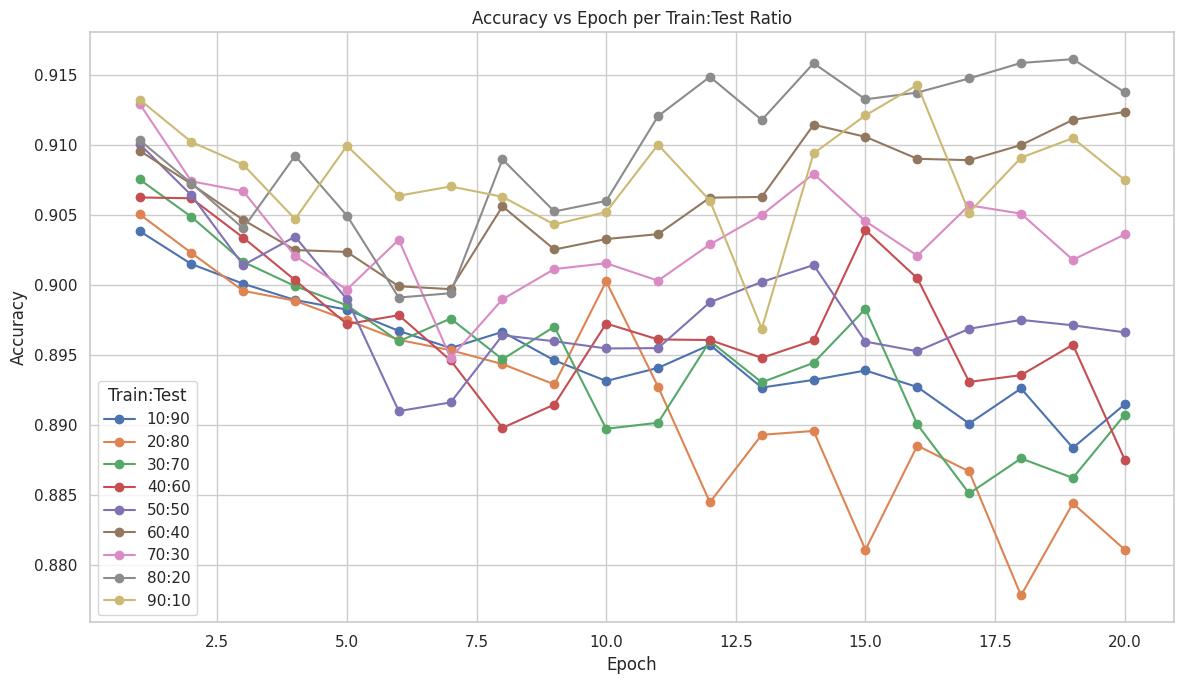

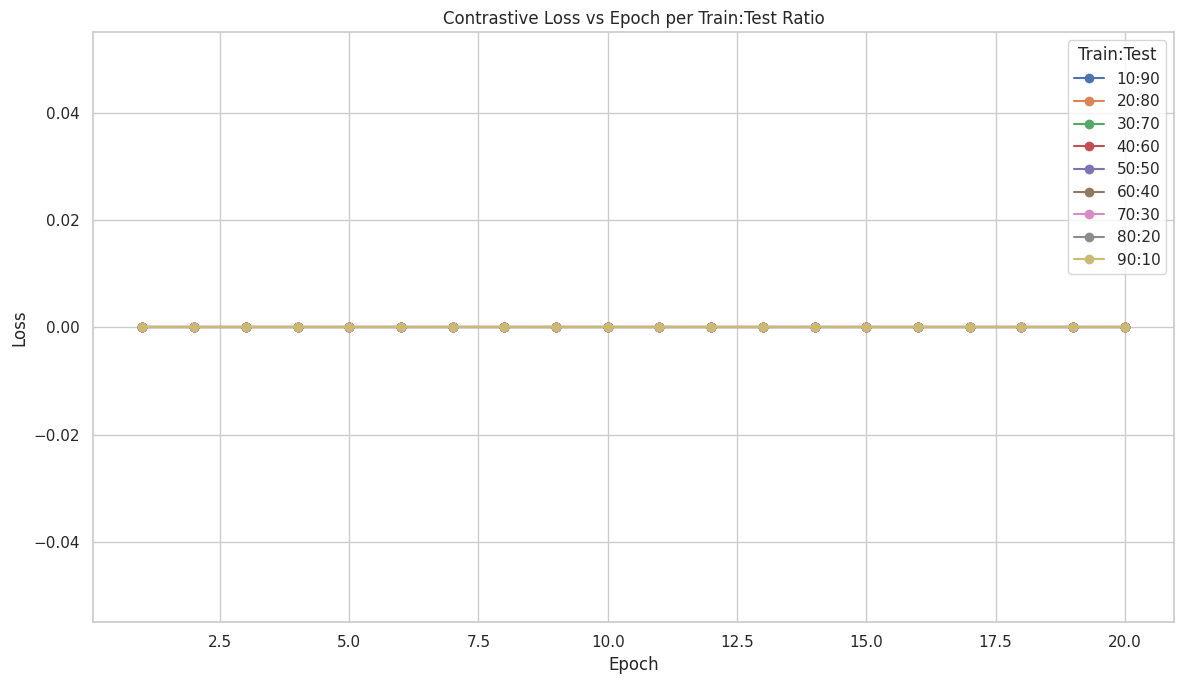

In [9]:
#Visualization of Results
# Set style for plots
sns.set(style="whitegrid")
ratios_unique = results_df[['train_pct', 'test_pct']].drop_duplicates()

# Accuracy vs Epoch
plt.figure(figsize=(12, 7))
for _, row in ratios_unique.iterrows():
    subset = results_df[
        (results_df['train_pct'] == row['train_pct']) & 
        (results_df['test_pct'] == row['test_pct'])
    ]
    label = f"{int(row['train_pct'])}:{int(row['test_pct'])}"
    plt.plot(subset['epoch'], subset['accuracy'], marker='o', label=label)
plt.title("Accuracy vs Epoch per Train:Test Ratio")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(title="Train:Test")
plt.tight_layout()
plt.show()

# Loss vs Epoch
plt.figure(figsize=(12, 7))
for _, row in ratios_unique.iterrows():
    subset = results_df[
        (results_df['train_pct'] == row['train_pct']) & 
        (results_df['test_pct'] == row['test_pct'])
    ]
    label = f"{int(row['train_pct'])}:{int(row['test_pct'])}"
    plt.plot(subset['epoch'], subset['loss'], marker='o', label=label)
plt.title("Contrastive Loss vs Epoch per Train:Test Ratio")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(title="Train:Test")
plt.tight_layout()
plt.show()


DINO (Self-Distillation with No Labels)

In [1]:
#Data Preprocessing
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

# Load dataset
train = pd.read_parquet("/kaggle/input/unsw-nb15/UNSW_NB15_training-set.parquet")
test = pd.read_parquet("/kaggle/input/unsw-nb15/UNSW_NB15_testing-set.parquet")
df = pd.concat([train, test])
df = df.drop(columns=['id', 'attack_cat'], errors='ignore')

# Preprocessing: Encode categorical columns
cat_cols = ['proto', 'service', 'state']
for col in cat_cols:
    df[col] = pd.factorize(df[col])[0]

X = df.drop('label', axis=1)
y = df['label']

# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X = pd.DataFrame(X_scaled, columns=X.columns)


2025-06-14 10:17:29.358803: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749896249.571225      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749896249.629498      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
#Define DINO Model Components (Teacher and Student)
def build_encoder(input_dim):
    """Builds the encoder network for DINO."""
    inputs = layers.Input(shape=(input_dim,))
    x = layers.Dense(256, activation='swish')(inputs)
    x = layers.Dense(128, activation='swish')(x)
    projection = layers.Dense(64)(x)  # Projection head
    return models.Model(inputs, projection)

def momentum_update(student_encoder, teacher_encoder, m=0.99):
    """Momentum update for the teacher model."""
    for student_var, teacher_var in zip(student_encoder.variables, teacher_encoder.variables):
        teacher_var.assign(m * teacher_var + (1 - m) * student_var)

def contrastive_loss(query, key, temperature=0.07):
    """Contrastive loss function used in DINO."""
    query = tf.math.l2_normalize(query, axis=1)
    key = tf.math.l2_normalize(key, axis=1)

    logits = tf.matmul(query, key, transpose_b=True) / temperature
    labels = tf.zeros(logits.shape[0], dtype=tf.int32)  # Positive pairs are the first in the logits

    loss = tf.nn.sparse_softmax_cross_entropy_with_logits(labels, logits)
    return tf.reduce_mean(loss)

def augment_batch(X):
    """Augmentation function: add noise and apply masking."""
    mask = (np.random.rand(*X.shape) > 0.15).astype(np.float32)
    noise = np.random.normal(0, 0.05, size=X.shape).astype(np.float32)
    return X * mask + noise


In [3]:
#Training DINO with Multiple Train-Test Ratios
ratios = [(10, 90), (20, 80), (30, 70), (40, 60), (50, 50), (60, 40), (70, 30), (80, 20), (90, 10)]
all_results = []

for train_pct, test_pct in ratios:
    print(f"\n--- Train:Test = {train_pct}:{test_pct} ---")

    # Split data according to the ratio
    X_train, X_test, y_train, y_test = train_test_split(
        X.values.astype(np.float32), y.values,
        test_size=test_pct / 100,
        stratify=y,
        random_state=42
    )

    # Initialize encoders and optimizer
    student_encoder = build_encoder(X_train.shape[1])
    teacher_encoder = build_encoder(X_train.shape[1])

    # Initialize teacher encoder weights with student encoder weights (momentum update)
    for s_var, t_var in zip(student_encoder.variables, teacher_encoder.variables):
        t_var.assign(s_var)

    optimizer = tf.keras.optimizers.Adam(3e-4)
    batch_size = 512
    epochs = 20
    num_samples = X_train.shape[0]

    for epoch in range(epochs):
        idx = np.random.permutation(num_samples)
        X_shuffled = X_train[idx]

        for i in range(0, num_samples, batch_size):
            batch = X_shuffled[i:i + batch_size]
            if batch.shape[0] < 2:
                continue

            x_q = augment_batch(batch)
            x_k = augment_batch(batch)

            with tf.GradientTape() as tape:
                z_q = student_encoder(x_q, training=True)
                z_k = teacher_encoder(x_k, training=True)
                loss = contrastive_loss(z_q, z_k)

            grads = tape.gradient(loss, student_encoder.trainable_variables)
            optimizer.apply_gradients(zip(grads, student_encoder.trainable_variables))

            # Momentum update of teacher
            momentum_update(student_encoder, teacher_encoder)

        print(f"Epoch {epoch + 1}/{epochs}, Loss: {loss.numpy():.4f}")

        # Evaluate the model (Random Forest classifier on SSL embeddings)
        X_train_ssl = student_encoder.predict(X_train)
        X_test_ssl = student_encoder.predict(X_test)

        rf = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
        rf.fit(X_train_ssl, y_train)
        y_pred = rf.predict(X_test_ssl)
        report = classification_report(y_test, y_pred, output_dict=True)

        acc = report['accuracy']
        f1_0 = report['0']['f1-score']
        f1_1 = report['1']['f1-score']

        all_results.append({
            'train_pct': train_pct,
            'test_pct': test_pct,
            'epoch': epoch + 1,
            'loss': float(loss.numpy()),
            'accuracy': acc,
            'f1_class_0': f1_0,
            'f1_class_1': f1_1
        })

        print(f"Accuracy: {acc:.4f}, F1 Class 0: {f1_0:.4f}, F1 Class 1: {f1_1:.4f}")



--- Train:Test = 10:90 ---


I0000 00:00:1749896382.785687      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1749896382.786371      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Epoch 1/20, Loss: 8.7080


I0000 00:00:1749896389.108592     117 service.cc:148] XLA service 0x7b31fc011610 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1749896389.109327     117 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1749896389.109346     117 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1749896389.181020     117 cuda_dnn.cc:529] Loaded cuDNN version 90300


130/806 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

I0000 00:00:1749896389.461961     117 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


806/806 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
7248/7248 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step
Accuracy: 0.8984, F1 Class 0: 0.8529, F1 Class 1: 0.9224
Epoch 2/20, Loss: 8.6557
806/806 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
7248/7248 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step
Accuracy: 0.8990, F1 Class 0: 0.8541, F1 Class 1: 0.9228
Epoch 3/20, Loss: 6.9899
806/806 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
7248/7248 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step
Accuracy: 0.8991, F1 Class 0: 0.8546, F1 Class 1: 0.9228
Epoch 4/20, Loss: 6.4220
806/806 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
7248/7248 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step
Accuracy: 0.8966, F1 Class 0: 0.8508, F1 Class 1: 0.9209
Epoch 5/20, Loss: 5.7784
806/806 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
7248/7248 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step
Accuracy: 0.8966, F1 Class 0: 0.8504, F1 Class 1: 0.9210
Epoch 6/20, Loss: 7.2598
806/806 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
7248/7248 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step
Accuracy: 0.8961, F1 Class 0: 0.8496, F1 Class 1: 0.9207
Epoch 7/20, Loss: 7.4452
806/

In [4]:
# Save the results after training for all ratios
results_df = pd.DataFrame(all_results)
results_df.to_csv('dino_ssl_rf_results_all_epochs.csv', index=False)
print("\nSaved results to 'dino_ssl_rf_results_all_epochs.csv'")



Saved results to 'dino_ssl_rf_results_all_epochs.csv'


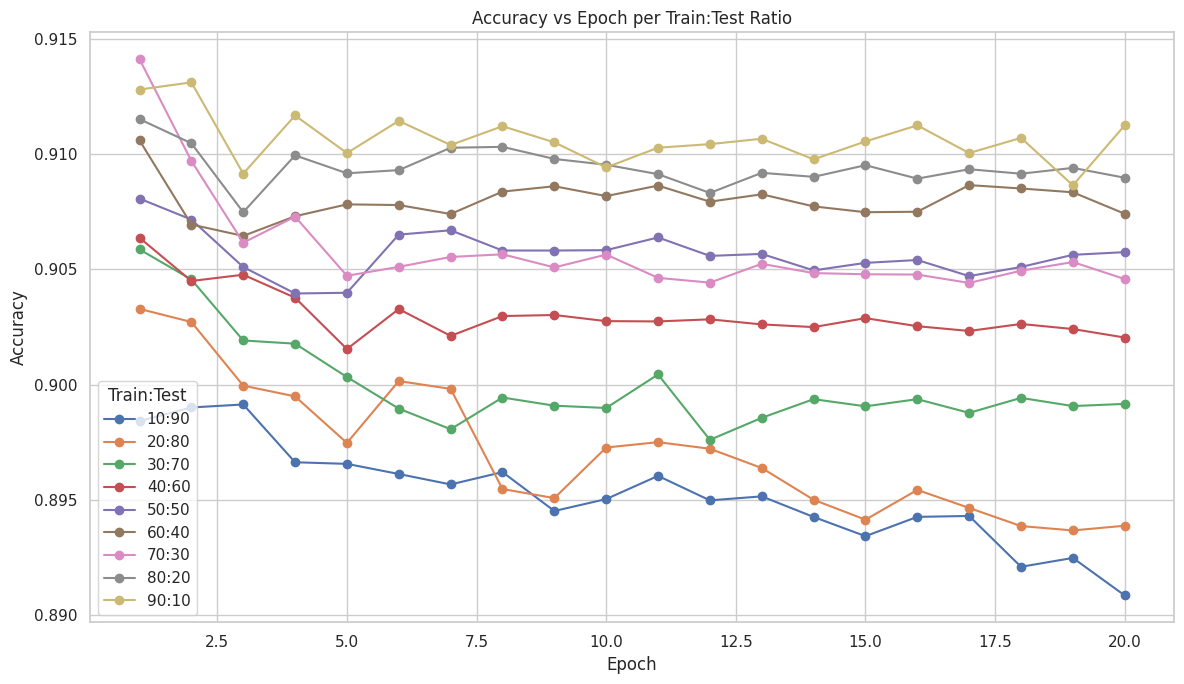

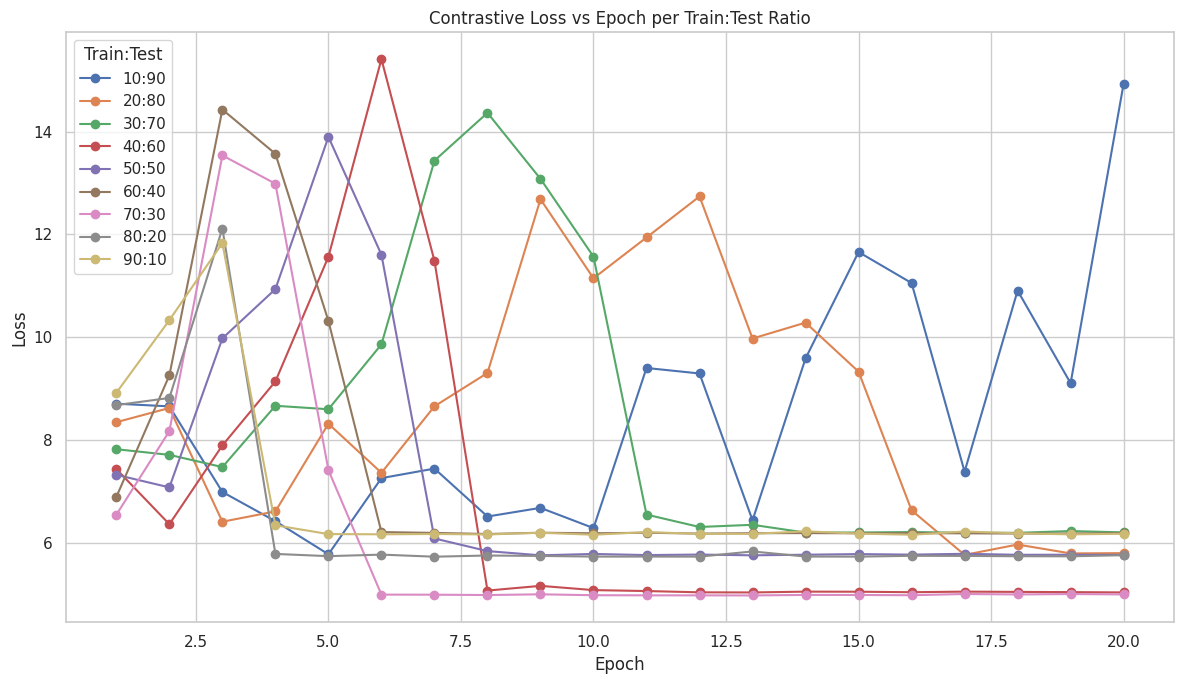

In [5]:
# Set style for plots
import seaborn as sns
sns.set(style="whitegrid")
ratios_unique = results_df[['train_pct', 'test_pct']].drop_duplicates()

# Accuracy vs Epoch
plt.figure(figsize=(12, 7))
for _, row in ratios_unique.iterrows():
    subset = results_df[
        (results_df['train_pct'] == row['train_pct']) & 
        (results_df['test_pct'] == row['test_pct'])
    ]
    label = f"{int(row['train_pct'])}:{int(row['test_pct'])}"
    plt.plot(subset['epoch'], subset['accuracy'], marker='o', label=label)
plt.title("Accuracy vs Epoch per Train:Test Ratio")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(title="Train:Test")
plt.tight_layout()
plt.show()

# Loss vs Epoch
plt.figure(figsize=(12, 7))
for _, row in ratios_unique.iterrows():
    subset = results_df[
        (results_df['train_pct'] == row['train_pct']) & 
        (results_df['test_pct'] == row['test_pct'])
    ]
    label = f"{int(row['train_pct'])}:{int(row['test_pct'])}"
    plt.plot(subset['epoch'], subset['loss'], marker='o', label=label)
plt.title("Contrastive Loss vs Epoch per Train:Test Ratio")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(title="Train:Test")
plt.tight_layout()
plt.show()
